<a href="https://colab.research.google.com/github/smsali97/cybersecurity-analytics-cmpe788/blob/main/Finding%20Network%20Attack%20Type%20through%20Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding the Attack Type using Clustering ( K Means Clustering)

In [97]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [98]:
hulk_df = pd.read_csv('Hulk-NoDefense.csv')
slowhttp_df = pd.read_csv('Slowhttptest-NoDefense.csv')
slowloris_df = pd.read_csv('Slowloris-NoDefense.csv')
tcpflood_df = pd.read_csv('TCPFlood-NoDefense(2).csv')

In [99]:
# checking if columns are the same
hulk_columns = set(hulk_df)
slowhttp_columns = set(slowhttp_df)
slowloris_columns = set(slowloris_df)
tcpflood_columns = set(tcpflood_df)

hulk_columns == slowhttp_columns == slowloris_columns == tcpflood_columns

True

In [100]:
# adding target column
hulk_df['attack_type'] = 'hulk'
slowhttp_df['attack_type'] = 'slow_http'
slowloris_df['attack_type'] = 'slow_loris'
tcpflood_df['attack_type'] = 'tcp_flood'

In [101]:
df = pd.concat([hulk_df,slowhttp_df,slowloris_df,tcpflood_df])
df.sample(5)

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,attack_type
39376,192.168.111.65-192.168.111.66-36904-80-6,192.168.111.65,36904,192.168.111.66,80,6,11/02/2021 09:17:10 AM,17914,22,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCPFlood-NoDefense,tcp_flood
277544,192.168.111.65-192.168.111.66-59644-80-6,192.168.111.65,59644,192.168.111.66,80,6,11/02/2021 09:06:59 AM,316912,8,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hulk-NoDefense,hulk
613645,192.168.111.65-192.168.111.66-34858-80-6,192.168.111.65,34858,192.168.111.66,80,6,11/02/2021 09:10:54 AM,320772,7,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hulk-NoDefense,hulk
187479,192.168.111.65-192.168.111.66-40744-80-6,192.168.111.65,40744,192.168.111.66,80,6,11/02/2021 09:22:20 AM,6416,19,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCPFlood-NoDefense,tcp_flood
455044,192.168.111.65-192.168.111.66-51772-80-6,192.168.111.65,51772,192.168.111.66,80,6,11/02/2021 09:09:02 AM,750591,8,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hulk-NoDefense,hulk


In [102]:
df.isna().sum()

Flow ID        0
Src IP         0
Src Port       0
Dst IP         0
Dst Port       0
              ..
Idle Std       0
Idle Max       0
Idle Min       0
Label          0
attack_type    0
Length: 85, dtype: int64

In [103]:

le = LabelEncoder()

print('All possible IPs: ',set(df['Src IP']) | set(df['Dst IP']))

df = df.drop(columns=['Src IP','Dst IP', 'Src Port', 'Dst Port'],axis=1)
# drop ip address ports

All possible IPs:  {'192.168.111.65', '192.168.111.255', '*.*.*.*', '0.0.0.0', '192.168.111.6', '192.168.111.199', '192.168.111.68', '255.255.255.255', '192.168.111.250', '192.168.111.66'}


In [104]:
df.isna().sum()
# dropping these columns, can later analyse if they are useful
df.drop(columns=['Flow ID','Label','Timestamp'],inplace=True)

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1151492 entries, 0 to 291759
Data columns (total 78 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Protocol                    1151492 non-null  int64  
 1   Flow Duration               1151492 non-null  int64  
 2   Total Fwd Packet            1151492 non-null  int64  
 3   Total Bwd packets           1151492 non-null  int64  
 4   Total Length of Fwd Packet  1151492 non-null  float64
 5   Total Length of Bwd Packet  1151492 non-null  float64
 6   Fwd Packet Length Max       1151492 non-null  float64
 7   Fwd Packet Length Min       1151492 non-null  float64
 8   Fwd Packet Length Mean      1151492 non-null  float64
 9   Fwd Packet Length Std       1151492 non-null  float64
 10  Bwd Packet Length Max       1151492 non-null  float64
 11  Bwd Packet Length Min       1151492 non-null  float64
 12  Bwd Packet Length Mean      1151492 non-null  float64
 13

In [106]:
df = df.dropna() # drop na values can handle as well

train_df, test_df = train_test_split(df, test_size=0.3, random_state=633, shuffle=True)

In [107]:
attack_types = ['hulk','slow_http','slow_loris','tcp_flood']




train_df_output = train_df['attack_type']
train_df_input =  train_df.drop(['attack_type'],axis=1)

scaler = MinMaxScaler()
train_df_input_scaled = scaler.fit_transform(train_df_input) # min max scaler, ideally need to customize


kmeans = KMeans(n_clusters=len(attack_types))
kmeans = kmeans.fit(train_df_input)




## Plotting 2D Scatter Plot (Dimensionality Reduction) for visualising class distinction of attack types

['hulk: red', 'slow_http: blue', 'slow_loris: green', 'tcp_flood: black']


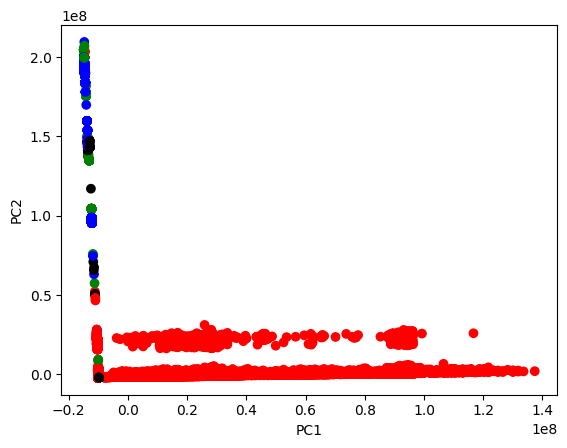

Hulk is significantly different from other attacks, also tcp flood is on the extreme end as well


In [108]:
pca = PCA()
x_new = pca.fit_transform(train_df_input)


color_map = {0: 'red', 1: 'blue', 2: 'green', 3: 'black'}
colors = [color_map[attack_types.index(i)] for i in train_df_output]

print([attack_types[i] + ': ' + color_map[i] for i in range(len(attack_types))])
plt.scatter(x_new[:,0], x_new[:,1], c = colors)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

print('Hulk is significantly different from other attacks, also tcp flood is on the extreme end as well')

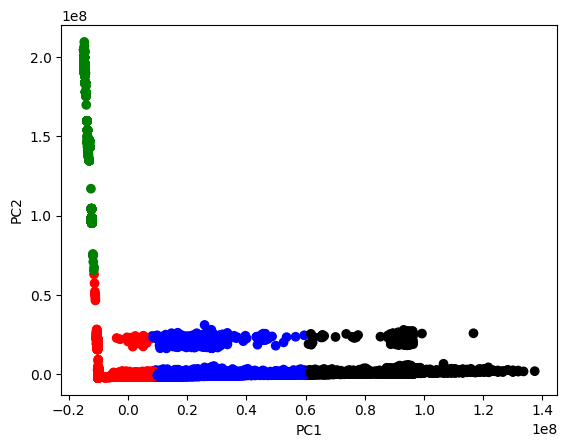

In [109]:

colors = [color_map[i] for i in kmeans.labels_]
plt.scatter(x_new[:,0], x_new[:,1], c = colors)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Using Support Vector Machine to identify Decision Bounaries

In [110]:
from sklearn.svm import SVC

clf = SVC()
clf.fit(train_df_input_scaled,train_df_output)

test_df_output = test_df['attack_type']
test_df_input =  test_df.drop(['attack_type'],axis=1)

scaler = MinMaxScaler()
test_df_input = scaler.fit_transform(test_df_input) # min max scaler, ideally need to customize

predicted_test_df_output = clf.predict(test_df_input)

# Results

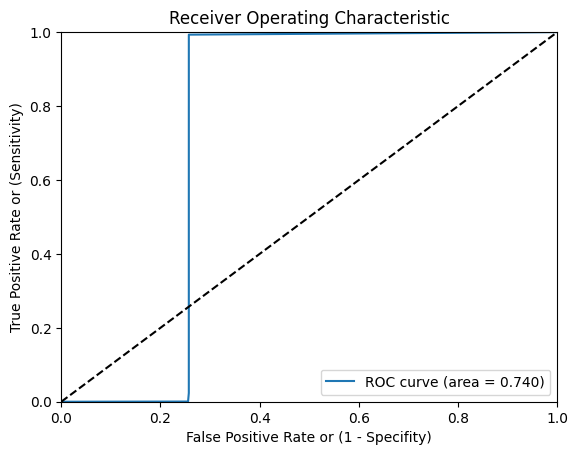

In [111]:
# Compute fpr, tpr, thresholds and roc auc
y_true = [attack_types.index(a) for a in test_df_output ]
y_score = [attack_types.index(a) for a in predicted_test_df_output ]

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## Feature Selection for improving Model's ROC score and ranking best features

### Recursive Feature Elimination

In [112]:
# clf = SVC(kernel="linear", C=1)
# rfe = RFE(clf, n_features_to_select=10)
# rfe.fit(train_df_input,train_df_output)

# print("Selected features: ", train_df_input.columns[rfe.support_])
# print("Feature ranking: ", rfe.ranking_)

# kf = KFold(n_splits=5)
# scores = []
# for train_index, test_index in kf.split(train_df):

    
#     X_train, X_test = train_df[selected_features].iloc[train_index], train_df[selected_features].iloc[test_index]
#     y_train, y_test = train_df_output.iloc[train_index], train_df_output.iloc[test_index]
    
#     scaler.fit_transform(X_train)
#     scaler.fit_transform(X_test)
    
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
    
#     y_pred = model.predict_proba(X_test)[:,1]
#     scores.append(roc_auc_score(y_test, y_pred))
    
# # Print the average AUC over all folds
# print("Average AUC: ", sum(scores) / len(scores))

### Lasso Method

In [113]:

X = train_df_input
y = [attack_types.index(a) for a in train_df_output ]
# Create a Lasso model
model = Lasso(alpha=0.1)
model.fit(X, y)

# Get the coefficients of the Lasso model
coef = model.coef_
# sort array by their absolute value
indices = np.argsort(np.abs(coef))[::-1]

/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.453e+03, tolerance: 1.370e+02
  model = cd_fast.enet_coordinate_descent(


In [114]:
# sort array by their absolute value
indices_t = indices[:20]
for i in range(len(indices_t)):
    index = indices_t[i]
    print(str(i+1) + ' ' + str(X.columns[index]) + ' ' + str(coef[index]))

1 Fwd Packet Length Max -0.0011315564710610297
2 Fwd Bytes/Bulk Avg 0.0008173787547607589
3 Packet Length Std -0.00046084997033473877
4 Bwd Packet Length Std -0.00037583522288496454
5 Subflow Bwd Bytes -0.00026462973066201733
6 Bwd Header Length -0.0001972594026241273
7 Packet Length Max 0.00015680786650122517
8 Packet Length Mean -0.0001555334581232633
9 Fwd Packets/s 0.0001474967729557858
10 Total Length of Fwd Packet 0.00014142123452443316
11 Average Packet Size -0.0001147186363667248
12 Bwd Packet Length Max -0.00010814791197591612
13 Total Length of Bwd Packet -0.00010491706871092809
14 Bwd Init Win Bytes -9.985102796607418e-05
15 Bwd Packets/s -7.539862449503243e-05
16 FWD Init Win Bytes 2.2803483534231404e-05
17 Bwd Segment Size Avg 2.0984617692490135e-05
18 Bwd Packet Length Mean 1.6024019620501595e-05
19 Bwd Bytes/Bulk Avg -1.5674133377195728e-05
20 Fwd Bulk Rate Avg -2.779092295894704e-06


As we can see here sharp decline after 13th value, so we'll just choose the top 13 values

In [117]:
kf = KFold(n_splits=5)
clf = SVC(probability=True)
scores = []
selected_features = X.columns[indices_t[:14]]
for train_index, test_index in kf.split(train_df):
    X_train, X_test = train_df[selected_features].iloc[train_index], train_df[selected_features].iloc[test_index]
    y_train, y_test = train_df_output.iloc[train_index], train_df_output.iloc[test_index]
    
    scaler.fit_transform(X_train)
    scaler.fit_transform(X_test)

    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    scores.append(y_pred)


In [ ]:
    
# Print the average AUC over all folds
print("Average AUC: ", sum(scores) / len(scores))